In [1]:
import os
import pandas as pd
import numpy as np

from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfVectorizer  # tf-idf

In [5]:
aclImdb_path = os.path.join("D:\\", "program", "programming", "study", "data", "aclImdb_v1")
reviews_train = load_files(os.path.join(aclImdb_path, "train"))
reviews_test = load_files(os.path.join(aclImdb_path, "test"))

### trainデータの作成

In [6]:
df_train = pd.DataFrame({"data": reviews_train["data"],
                         "target": reviews_train["target"]})

df_train = df_train.drop(df_train[df_train["target"] == 2].index, axis=0)
df_train["data"] = df_train["data"].str.decode('utf-8').str.replace("b['\"]|'|<br />", "", regex=True)

### testデータの作成

In [7]:
df_test = pd.DataFrame({"data": reviews_test["data"],
                        "target": reviews_test["target"]})
df_test = df_test.drop(df_test[df_test["target"] == 2].index, axis=0)
df_test["data"] = df_test["data"].str.decode('utf-8').str.replace("b['\"]|'|<br />", "", regex=True)

In [9]:
pipe = make_pipeline(
    TfidfVectorizer(min_df=5, norm=None),
    LogisticRegression(max_iter=300)
)

param_grid = {"logisticregression__C": 10.0 ** np.arange(-3, 1)}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(df_train["data"], df_train["target"])
print("Best cross-validation score: ", grid.best_score_)

Best cross-validation score:  0.8939999999999999


In [ ]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]

# 訓練データセットを変換
X_train = vectorizer.transform(df_train["data"])

# それぞれの特徴量の各単語の最大値をとってきている、
# これによって一度でもよく使われる単語があればその単語の値は高くなる
max_value = X_train.max(axis=0).toarray().flatten()
sorted_byidf = max_value.argsort()

# 特徴量名を取得
feature_names = np.array(vectorizer.get_feature_names_out())

print("Features with lowest tfidf:\n", feature_names[sorted_byidf[:20]])

print("Features with highest tfidf:\n", feature_names[sorted_byidf[-20:]])

Features with lowest tfidf:
 ['poignant' 'disagree' 'instantly' 'importantly' 'lacked' 'occurred'
 'currently' 'altogether' 'nearby' 'undoubtedly' 'directs' 'avoided'
 'fond' 'stinker' 'emphasis' 'commented' 'disappoint' 'realizing'
 'downhill' 'inane']
Features with highest tfidf:
 ['coop' 'kornbluth' 'europa' 'roy' 'blob' 'dillinger' 'hackenstein'
 'basket' 'homer' 'dominick' 'gadget' 'bridget' 'taker' 'vargas' 'jesse'
 'victor' 'timon' 'the' 'rob' 'titanic']


In [19]:
X_train.max(axis=0).shape

(1, 27969)

In [ ]:
sorted_by_idf = np.argsort(vectorizer.idf_)  # これはコーパス全体でどれだけ珍しいかだけを基準にしている
print("Features with lowest idf:\n", feature_names[sorted_by_idf[:100]])

Features with lowest idf:
 ['the' 'and' 'of' 'to' 'this' 'is' 'in' 'it' 'that' 'but' 'for' 'with'
 'was' 'as' 'on' 'movie' 'not' 'have' 'be' 'one' 'are' 'film' 'all' 'at'
 'you' 'its' 'an' 'by' 'so' 'from' 'like' 'who' 'if' 'his' 'out' 'just'
 'about' 'they' 'or' 'has' 'he' 'there' 'what' 'some' 'good' 'more' 'when'
 'time' 'up' 'very' 'even' 'only' 'no' 'my' 'see' 'would' 'can' 'really'
 'story' 'well' 'which' 'had' 'me' 'than' 'much' 'were' 'their' 'get'
 'other' 'been' 'do' 'most' 'her' 'also' 'into' 'first' 'made' 'dont'
 'great' 'how' 'because' 'will' 'people' 'make' 'way' 'bad' 'could'
 'after' 'any' 'too' 'then' 'movies' 'them' 'we' 'watch' 'think' 'acting'
 'seen' 'characters' 'she']


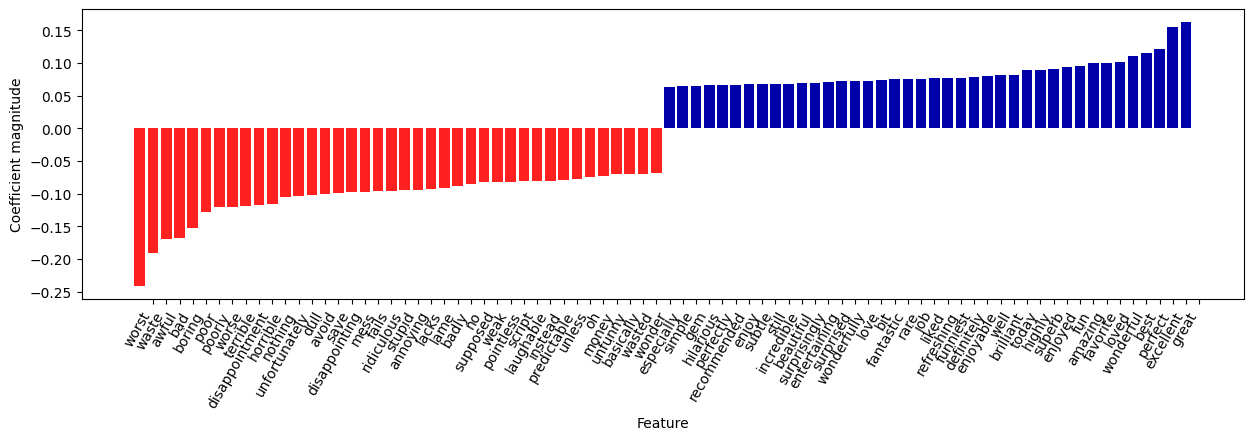

In [ ]:
import mglearn
mglearn.tools.visualize_coefficients(
    # このデータは否定的か、肯定的かを判断するもののため、単語がnegativeかpositiveかをcoef_が返してくれる
    grid.best_estimator_.named_steps["logisticregression"].coef_,
    feature_names, n_top_features=40
)